## IDS 576 - Assignment 3
10/20/2019
#### Team 3:
Scott Brewer (sbrewe5@uic.edu)  
Rahul Shukla (rshukl4@uic.edu)

## 1. RNN for Language Modeling (40pt)

In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
from torchtext import data
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import string
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

%matplotlib inline

In [3]:
def generate_trigrams(x):
    res = []
    n_grams = list(zip(*[x[i:] for i in range(3)]))
    for n_gram in n_grams:
        res.append(' '.join(n_gram))
    return res

In [5]:
import spacy

In [6]:
nlp = spacy.load("en_core_web_sm")

In [10]:
import torch
from torchtext import data, datasets
import random

In [12]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
##############importing imdb daasets#############
TEXT = data.Field(preprocessing=generate_trigrams)
LABEL = data.LabelField(dtype=torch.float)
train_data, test_data = datasets.IMDB.splits(TEXT,LABEL)
print(vars(train_data.examples[0]))
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.9)
TEXT.build_vocab(train_data)
dictionary = dict(TEXT.vocab.freqs)

{'text': ["I don't know", "don't know who", 'know who could', 'who could find', 'could find fault', 'find fault with', 'fault with a', 'with a simply', 'a simply human', 'simply human and', 'human and funny', 'and funny film', 'funny film like', 'film like this', 'like this with', 'this with lots', 'with lots of', 'lots of delights', 'of delights for', 'delights for your', 'for your heart.', 'your heart. I', 'heart. I enjoyed', 'I enjoyed each', 'enjoyed each minute', 'each minute of', 'minute of it', 'of it and', 'it and guessed', 'and guessed the', 'guessed the ending', 'the ending half', 'ending half way', 'half way through', 'way through the', 'through the movie', 'the movie --', 'movie -- but', '-- but that', 'but that did', 'that did not', 'did not disappoint', 'not disappoint me', 'disappoint me at', 'me at all.', 'at all. It', 'all. It will', 'It will not', 'will not only', 'not only touch', 'only touch your', 'touch your heart', 'your heart but', "heart but it's", "but it's su

In [13]:
markov = pd.DataFrame.from_dict(dictionary,orient="index")
markov = markov.reset_index()
markov.columns = ['trigrams','cnt']
markov['bigram'] =markov.trigrams.apply(lambda x: " ".join(x.split(' ')[:2]))
markov['target'] =markov.trigrams.apply(lambda x: x.split(' ')[2])
inp_cnt = pd.DataFrame(markov.groupby("bigram",as_index=False)["cnt"].sum())

#### 1.b. Change the output appropriately in ‘Simple Sentiment Analysis.ipynb’ to build an LSTM based language model. Plot the training performance as a function of epochs/iterations

In [15]:
SEED = 1234

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field()
LABEL = data.LabelField(dtype=torch.float)

In [16]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

In [17]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [18]:
print(vars(train_data.examples[0]))
train_data, valid_data = train_data.split(random_state=random.seed(SEED),split_ratio=0.25)

{'text': ['I', "don't", 'know', 'who', 'could', 'find', 'fault', 'with', 'a', 'simply', 'human', 'and', 'funny', 'film', 'like', 'this', 'with', 'lots', 'of', 'delights', 'for', 'your', 'heart.', 'I', 'enjoyed', 'each', 'minute', 'of', 'it', 'and', 'guessed', 'the', 'ending', 'half', 'way', 'through', 'the', 'movie', '--', 'but', 'that', 'did', 'not', 'disappoint', 'me', 'at', 'all.', 'It', 'will', 'not', 'only', 'touch', 'your', 'heart', 'but', "it's", 'such', 'a', 'good', 'family', 'friendly', 'film--we', 'need', 'many', 'more', 'like', 'these!'], 'label': 'pos'}


In [19]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 6250
Number of validation examples: 18750
Number of testing examples: 25000


In [20]:
TEXT.build_vocab(train_data, max_size=1000)
LABEL.build_vocab(train_data)

In [21]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 1002
Unique tokens in LABEL vocabulary: 2


In [23]:
BATCH_SIZE = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

In [24]:
class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim,BATCH_SIZE,output_dim):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, output_dim)
        
    def forward(self, x):        
        embedded = self.embedding(x)
        output, (hidden,cell) = self.rnn(embedded)
        dim = output.size()
        output = output.view(-1, output.shape[2])
        output1 = F.log_softmax(output,dim=1)
        
        if BATCH_SIZE==dim[1]:
            output1 = output1.view(-1,OUTPUT_DIM,BATCH_SIZE)
        else:
            output1 = output1.view(dim[1],OUTPUT_DIM,-1)
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]       
        return output1

In [25]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
OUTPUT_DIM = len(TEXT.vocab)
model = RNN(INPUT_DIM, EMBEDDING_DIM,BATCH_SIZE,OUTPUT_DIM)

In [26]:
optimizer = optim.SGD(model.parameters(), lr=1e-1)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

In [28]:
def train(model, iterator, optimizer, criterion,BATCH_SIZE):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_label_count = 0 
    loss=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()   
        predictions = model(batch.text)

        dim = predictions.size()
        if dim[2] !=BATCH_SIZE:
            BATCH_SIZE = dim[2]
            
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(BATCH_SIZE,-1)
        _,preds = torch.max(predictions,1)
        labels = batch.text.view(-1,BATCH_SIZE)
        labels = labels[1:]
        pad = torch.tensor([1]*BATCH_SIZE,device="cuda:0").view(-1,BATCH_SIZE)
        labels = torch.cat((labels,pad),0)
        loss = criterion(predictions,labels)
        acc = torch.sum(preds == labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_label_count+= labels.numel()
        
    return epoch_loss / len(iterator) , (epoch_acc /epoch_label_count)

In [29]:
N_EPOCHS = 10
train_losses = []
valid_losses = []
for epoch in range(N_EPOCHS):
    train_loss,train_acc = train(model, train_iterator, optimizer, criterion,BATCH_SIZE)
    train_losses.append(train_loss)
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% ')#| Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

| Epoch: 01 | Train Loss: 5.949 | Train Acc: 9.33% 
| Epoch: 02 | Train Loss: 5.609 | Train Acc: 9.76% 
| Epoch: 03 | Train Loss: 5.593 | Train Acc: 9.38% 
| Epoch: 04 | Train Loss: 5.597 | Train Acc: 9.03% 
| Epoch: 05 | Train Loss: 5.599 | Train Acc: 8.99% 
| Epoch: 06 | Train Loss: 5.596 | Train Acc: 8.79% 
| Epoch: 07 | Train Loss: 5.597 | Train Acc: 9.14% 
| Epoch: 08 | Train Loss: 5.599 | Train Acc: 8.97% 
| Epoch: 09 | Train Loss: 5.599 | Train Acc: 9.69% 
| Epoch: 10 | Train Loss: 5.593 | Train Acc: 9.26% 


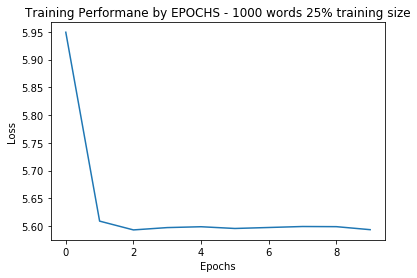

In [30]:
plt.plot(train_losses)
plt.title("Training Performane by EPOCHS - 1000 words 25% training size")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#### 1.2. For each model, describe the key design choices made. Briefly mention how each choice influences training time and generative quality

Markov model we went with the trigrams and there was no difficulty in calculating the probabilities and prediction.

For LSTM there was an input layer followed by embedding then lstm layer. The input was the tokenized text and output also the tokenized text offsetted by 1 place. Ex) if input is {This,is,my,favorite,movie} then output is {is,my,favorite,movie}

We took 25% training data with max 1000 words with batch size 10 to train our lstm model.
If we increased the number of words then the model couldn't be loaded into the gpu as there was insufficient memory
If we increased the training data to higher percentage say 50% or 80% then notebook got disconnected from the server randomly. This error didn't go when we tried to run the code as standalone .py file instead of a python notebook
When we reduced the batch size to 1 then model took longer time to train and when we increased it to 64 then there was memory error once again. We settled at Batch Size 10
Due to this limited training size and words the quality of sentence formed by predicition was affected considerably.The prediction didn't give out a coherent sentence as we would have liked.

#### 1.3. For each model, starting with the phrase ”My favorite movie ”, sample the next few words and create a 20 word generated review

Markov Predictions:

In [46]:
def generate_sentence(sentence,no_preds,prediction_length):
    prediction_length -= len(sentence.split(" ")) 
    for j in range(0,no_preds):
        pred_sentence = sentence
        bi = " ".join(pred_sentence.split(" ")[1:])
        for i in range(0,prediction_length):
            poss_pred = np.array(markov.target[markov.bigram==bi])
            scores = np.array(markov.cnt[markov.bigram==bi])
            length = inp_cnt.cnt[inp_cnt.bigram==bi]
            probs = scores/length.iloc[0]
            pred = random.choice(list(enumerate(probs)))[0]
            pred = poss_pred[pred]
            pred_sentence = pred_sentence + " " + pred
            bi = " ".join([bi.split(" ")[1],pred])
        pred_length = len(pred_sentence.split(sep=' '))
        print(f"Generated Review {str(j+1)}: ({pred_length}) {pred_sentence}\n")
        
generate_sentence("my favorite movie",5,20)

Generated Review 1: (20) my favorite movie Dawn of the cave the siblings intended to fool Coburn with PAT GARRETT & BILLY THE KID

Generated Review 2: (20) my favorite movie (next to Ranma)... and probably saying hello to Oshii's creation "superlivemation": not quite at the worlds described

Generated Review 3: (20) my favorite movie growing up, you can drive Grandpa's car. He can't trust anyone for a self-confessed b-grade horror) and

Generated Review 4: (20) my favorite movie he plays Wilhelm Grimm, a sad day in time. We never learn his true colors--enslaving women, oppressing

Generated Review 5: (20) my favorite movie at all!<br /><br />He falls victim to stereotypical male vs. female characters here are better played, and



RNN Predictions:

In [44]:
for j in range(5):
    inp =torch.tensor([[TEXT.vocab.stoi["my"]],[TEXT.vocab.stoi["favorite"]],[TEXT.vocab.stoi["movie"]]],device="cuda:0")
    for i in range(16):
        op = model(inp)
        op = op.squeeze(0)
        op = op[:,op.size()[1]-1].detach().cpu().numpy()
        op = np.sort(op)[::-1]
        op = op[:500] 
        new_inp = torch.tensor(np.where(op==np.random.choice(op,1)),device="cuda:0")
        inp = torch.cat((inp,new_inp))
    
    generated_text = ""
    for val in inp:
        generated_text = generated_text + " " + TEXT.vocab.itos[val]
    gen_length = len(generated_text.split(sep=' '))
    print(f"Generated Review {str(j+1)}: ({gen_length}) {generated_text}\n")

Generated Review 1: (20)  my favorite movie looking (and seeing I me I My films between least While course American give there nothing

Generated Review 2: (20)  my favorite movie favorite all might last only lot once times stupid around looking as short old acting worth

Generated Review 3: (20)  my favorite movie between women as time such performance Of someone school For one DVD able person At point

Generated Review 4: (20)  my favorite movie very help lot time never movie The To goes isn't father enjoyed definitely />I though classic

Generated Review 5: (20)  my favorite movie film, movies His will pretty gave find TV most To father quite on life several that



## 2. Sequence to Sequence Model for Translation (40pt)

In [ ]:
%matplotlib inline


Translation with a Sequence to Sequence Network and Attention
*************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_  
Modified by Scott Brewer for IDS576 HW3 Q2 assignment.

In this project we will be teaching a neural network to translate from
French to English. (shifted to Italian)

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

And for more, read the papers that introduced these topics:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` to use to later replace rare words.




In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<SOS>": 0,"<EOS>": 1}
        self.word2count = {}
        self.index2word = {0: "<SOS>", 1: "<EOS>"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [6]:
MAX_LENGTH = 10
SEED = 0

vocab_filter = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p, reverse = False):
    if reverse == True:
        return len(p[0].split(' ')) < MAX_LENGTH and \
                len(p[1].split(' ')) < MAX_LENGTH and \
                p[1].startswith(vocab_filter)
    else:
        return len(p[1].split(' ')) < MAX_LENGTH and \
                len(p[0].split(' ')) < MAX_LENGTH and \
                p[0].startswith(vocab_filter)


def filterPairs(pairs, reverse = False):
    return [pair for pair in pairs if filterPair(pair, reverse=reverse)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs, reverse=reverse)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    # Subtract 2 to remove SOS and EOS from count
    print(input_lang.name, input_lang.n_words-2)
    print(output_lang.name, output_lang.n_words-2)
    return input_lang, output_lang, pairs

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences. We then combine all tensors into a single tensor for memory effieciency

In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ') if word != '<EOS>']


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# Below was intended to send a single tensor of index pairs to the gpu and then to iterate over it
# Unfortunately, the zero buffering in the tensor of shorter sentences degraded performance
# So I reverted back to creating a list of tensors for iteration, thus not using this function
def tensorsForEpochs(pairs, epochs):
    random.seed(SEED)
    input_tensor = torch.zeros([epochs, MAX_LENGTH], dtype=torch.long, device=device)
    target_tensor = torch.zeros([epochs, MAX_LENGTH], dtype=torch.long, device=device)
    for epoch in range(epochs):
        tfp_in, tfp_tgt = tensorsFromPair(random.choice(pairs))
        input_tensor[epoch][0:len(tfp_in)] = tfp_in.flatten()
        target_tensor[epoch][0:len(tfp_tgt)] = tfp_tgt.flatten()
    return input_tensor, target_tensor

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        self.gru.flatten_parameters()
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        # (1,1) is for numlayers=1, batchsize=1, shifted to randn from zeros
        return torch.randn(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Simple Decoder  
 
In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

This simple decoder is included for reference, but never actually used.



#### Attention Decoder

If only the context vector is passed betweeen the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

In [11]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size #256
        self.output_size = output_size #n_words in output vocab
        self.dropout_p = dropout_p
        self.max_length = max_length #10

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        # shifted to randn vs zeros
        return torch.randn(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

These are helper functions to print time elapsed and estimated time remaining given the current time and progress %. This is also a plotting helper to plot epochs vs loss. Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

In [12]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.switch_backend('agg')

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the `<SOS>` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but "when the trained network is exploited, it may exhibit instability". 
<http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf>.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
"teacher_forcing_ratio" up to use more of it.




In [14]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    #input_length = input_tensor.shape
    #target_length = target_tensor.shape

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei, token in enumerate(input_tensor):
        #print(token, token.dtype)
        encoder_output, encoder_hidden = encoder(token, encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    '''
    # See below for shortened version of this section for my own understanding and better clarity
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            print(decoder_output.shape, target_tensor[di])
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            print(decoder_output.shape, target_tensor[di])
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break
    '''
    
    for di, token in enumerate(target_tensor):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # Recall that first input is always SOS, thus current token is always compared to pred
        
        # Criterion expects batch as first dim, so must unsqeeze token to mimic batch size of one
        #loss += criterion(decoder_output, token.unsqueeze(0))
        loss += criterion(decoder_output, token)

        if use_teacher_forcing:
            # Teacher forcing to feed current target token as next input
            decoder_input = token 
        else:
            # Without teacher forcing: use its own predictions as the next input
            # topk extracts top softmax result
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input
            if decoder_input.item() == EOS_token:
                break
            
    
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / (di+1)

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [15]:
def trainIters(pairs, encoder, decoder, epochs, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    print('Building tensors...')
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(epochs)]
    #training_pairs = tensorsForEpochs(pairs, epochs)
    criterion = nn.NLLLoss()
    print('Training...')
    for epoch, training_pair in enumerate(training_pairs, 1): #range(1, epochs + 1):
        #training_pair = training_pairs[epoch - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / epochs),
                                         epoch, epoch / epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
    return plot_losses

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.

We can evaluate random sentences from the training set or a batch of given sentences and print out the
input, target, and output to make some subjective quality judgements:

In [16]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
def evaluateRandomly(pairs, encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        
def evaluateBatch(pairs, encoder, decoder):
    output_pairs = []
    for pair in pairs:
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
        output_pairs.append((output_sentence, pair[0]))
    return output_pairs

#### 2.1. Train the sequence to sequence model (Model 1) provided for a language pair where the output is English and the input is a language of your choice - in this case, Italian.

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU (or about 20 minutes on a GPU) we'll get some
reasonable results.

In [17]:
input_lang, output_lang, pairs = prepareData('eng', 'ita', True)
print(random.choice(pairs))

Reading lines...
Read 331799 sentence pairs
Trimmed to 30715 sentence pairs
Counting words...
Counted words:
ita 5218
eng 3059
['io sono qui per aiutarti .', 'i m here to help you .']


In [75]:
# Run this the first time to initialize the RNNs
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

In [76]:
# Run this to actually start the training loop, or to continue the training loop
plot_losses = trainIters(pairs, encoder1, attn_decoder1, 75000, print_every=5000)

Building tensors...
Training...
1m 12s (- 16m 51s) (5000 6%) 3.1204
2m 22s (- 15m 24s) (10000 13%) 2.3709
3m 33s (- 14m 12s) (15000 20%) 2.0159
4m 44s (- 13m 1s) (20000 26%) 1.7784
5m 54s (- 11m 48s) (25000 33%) 1.5506
7m 4s (- 10m 37s) (30000 40%) 1.4001
8m 16s (- 9m 26s) (35000 46%) 1.2681
9m 26s (- 8m 15s) (40000 53%) 1.1758
10m 37s (- 7m 4s) (45000 60%) 1.0728
11m 48s (- 5m 54s) (50000 66%) 0.9720
12m 57s (- 4m 42s) (55000 73%) 0.9143
14m 8s (- 3m 32s) (60000 80%) 0.8631
15m 21s (- 2m 21s) (65000 86%) 0.8163
16m 33s (- 1m 10s) (70000 93%) 0.7393
17m 45s (- 0m 0s) (75000 100%) 0.7192


<Figure size 432x288 with 0 Axes>

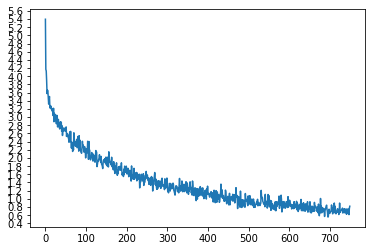

In [77]:
%matplotlib inline
showPlot(plot_losses)

As expected, loss decreased.

In [78]:
# Save the encoder and decoder
import pickle
model_path = '/home/team3/IDS576/models'
with open(model_path+'/eng-ita_encoder1.pkl', 'wb') as f:
    pickle.dump(encoder1, f)
with open(model_path+'/eng-ita_attn_decoder1.pkl', 'wb') as f:
    pickle.dump(attn_decoder1, f)

In [18]:
# Reload the saved encoder and decoder
import pickle
model_path = '/home/team3/IDS576/models'
with open(model_path+'/eng-ita_encoder1.pkl', 'rb') as f:
    encoder1 = pickle.load(f)
with open(model_path+'/eng-ita_attn_decoder1.pkl', 'rb') as f:
    attn_decoder1 = pickle.load(f)

In [19]:
evaluateRandomly(pairs, encoder1, attn_decoder1)

> siete noiosi .
= you re boring .
< you re boring . <EOS>

> noi ci incontriamo con tom tra tre ore .
= we re meeting tom in three hours .
< we re meeting tom tom in three hours . <EOS>

> lui non e americano .
= he is not an american .
< he is not perfect . <EOS>

> non stiamo prendendo nulla .
= we re not taking anything .
< we re not talking anything . <EOS>

> tu non sei malato .
= you re not sick .
< you re not sick . <EOS>

> sto aspettando una lettera da tom .
= i m waiting for a letter from tom .
< i m waiting for a call tom . <EOS>

> tu sei un ragazzo intelligente .
= you re a bright boy .
< you re a smart boy . <EOS>

> avete ragione ovviamente .
= you re right of course .
< you re all right right . <EOS>

> loro sono dappertutto .
= they re everywhere .
< they re dangerous . <EOS>

> io sono ansiosa di vederlo .
= i m anxious to see it .
< i m anxious to see it . <EOS>



/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1565272271120/wor

#### 2.2. Now train another model (Model 2) for the reverse (i.e., from English to the language you chose). In this model, use the GloVe 100 dimensional embeddings (see notebook 4, cell 2 for an example) while training.

The following GloVe loading and use code were adapted from this post https://medium.com/@martinpella/how-to-use-pre-trained-word-embeddings-in-pytorch-71ca59249f76

In [23]:
# Only run once - run next cell to reload pickled files

# bcolz provides columnar, chunked data containers that can be compressed either in-memory and on-disk.
# bcolz is used here due to the size of the glove data
import bcolz

glove_path = '/home/team3/IDS576/glove'
words = []
idx = 0
word2idx = {}

# Initialize bcolz array on disk
vectors = bcolz.carray(np.zeros(1), rootdir=f'{glove_path}/6B.100.dat', mode='w')

# Open and parse glove file
with open(f'{glove_path}/glove.6B.100d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)

# Write vector data to bcolz array on disk
vectors = bcolz.carray(vectors[1:].reshape((400000, 100)), rootdir=f'{glove_path}/6B.100.dat', mode='w')
vectors.flush()

with open(f'{glove_path}/6B.100_words.pkl', 'wb') as f:
    pickle.dump(words, f)
    
with open(f'{glove_path}/6B.100_idx.pkl', 'wb') as f:
    pickle.dump(word2idx, f)

In [20]:
# Run this to load glove data

import bcolz

glove_path = '/home/team3/IDS576/glove'
vectors = bcolz.open(f'{glove_path}/6B.100.dat')[:]

with open(f'{glove_path}/6B.100_words.pkl', 'rb') as f:
    words = pickle.load(f)
    
with open(f'{glove_path}/6B.100_idx.pkl', 'rb') as f:
    word2idx = pickle.load(f)

glove = {w: vectors[word2idx[w]] for w in words}

In [21]:
# import our sentences pairs and associated vocabs
MAX_LENGTH = 10

vocab_filter = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

input_lang, output_lang, pairs = prepareData('eng', 'ita', False)
print(random.choice(pairs))

Reading lines...
Read 331799 sentence pairs
Trimmed to 30715 sentence pairs
Counting words...
Counted words:
eng 3059
ita 5218
['i m giving it to you .', 'te la sto dando .']


In [22]:
# Build vocab and check it against glove
cnt = 0
target_vocab = input_lang.word2index
for word in target_vocab:
    try:
        glove[word]
    except:
        print(f'The word "{word}" is not in GloVe.')
        cnt += 1
if cnt > 0:
    print(f'{cnt} words are not in GloVe.')
else:
    print('All of our words are in GloVe')

The word "<SOS>" is not in GloVe.
The word "<EOS>" is not in GloVe.
2 words are not in GloVe.


In [23]:
# Set weight matrix size as vocab + 2 to account for the SOS and EOS chars in our vocab
matrix_len = len(target_vocab) + 2
weights_matrix = np.zeros((matrix_len, 100))
words_found = 0

# Start fill of weight matrix at 2 to account for the SOS and EOS chars in our vocab at indices 0 and 1
for i, word in enumerate(target_vocab, 2):
    try:
        #print(i, word)
        weights_matrix[i] = glove[word]
        words_found += 1
    except KeyError:
        print(f'{word} not found.') #weights_matrix[i] = np.random.normal(scale=0.6, size=(emb_dim, ))
weights_matrix = torch.from_numpy(weights_matrix).to(device)
print(f'Words Found: {words_found} out of {len(target_vocab)}')
print(weights_matrix.shape, weights_matrix.dtype, weights_matrix.is_cuda)

<SOS> not found.
<EOS> not found.
Words Found: 3059 out of 3061
torch.Size([3063, 100]) torch.float64 True


Define new encoder that will import the matrix of GloVe embeddings as the the embedding layer weights.

In [24]:
def create_emb_layer(weights_matrix, non_trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape  # vocab size x 100
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class GloveEncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, batch_size=1):
        super(GloveEncoderRNN, self).__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix, True)
        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        self.gru = nn.GRU(embedding_dim, hidden_size, num_layers)

    def forward(self, inp, hidden):
        embedded = self.embedding(inp).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size, device=device)

In [88]:
# Note that hidden size defines the GRU size, not the number of embeddings in this model
# Instead we use GloVe embed size of 100 as determined in the GloVe loading process
hidden_size = 256
encoder2 = GloveEncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

In [89]:
# Run to train model or rerun to continue training model
plot_losses = trainIters(pairs, encoder2, attn_decoder2, 75000, print_every=5000)

Building tensors...
Training...
1m 3s (- 14m 43s) (5000 6%) 4.4445
2m 5s (- 13m 32s) (10000 13%) 3.7412
3m 4s (- 12m 19s) (15000 20%) 3.4956
4m 4s (- 11m 11s) (20000 26%) 3.3069
5m 3s (- 10m 7s) (25000 33%) 3.0956
6m 4s (- 9m 7s) (30000 40%) 2.9651
7m 6s (- 8m 7s) (35000 46%) 2.8522
8m 7s (- 7m 6s) (40000 53%) 2.6898
9m 8s (- 6m 5s) (45000 60%) 2.6049
10m 9s (- 5m 4s) (50000 66%) 2.5045
11m 10s (- 4m 3s) (55000 73%) 2.3931
12m 12s (- 3m 3s) (60000 80%) 2.3193
13m 13s (- 2m 2s) (65000 86%) 2.2641
14m 14s (- 1m 1s) (70000 93%) 2.1512
15m 15s (- 0m 0s) (75000 100%) 2.0936


<Figure size 432x288 with 0 Axes>

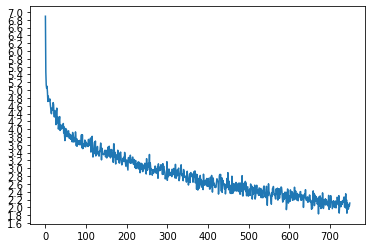

In [90]:
showPlot(plot_losses)

In [44]:
# After running the 5 sentences, I wanted to conduct more training,
# especially as the GloVe encoder loss is more than the base encoder
# Warnings are set to ignore due to memory fragmentation warning after reloading a pickled model
# The solution involves flatten_parameters in the model, but I can't get it to work.
import warnings
warnings.filterwarnings("ignore")
plot_losses = trainIters(pairs, encoder2, attn_decoder2, 75000, print_every=5000)
warnings.filterwarnings("default")

Building tensors...
Training...
1m 11s (- 16m 36s) (5000 6%) 2.0749
2m 18s (- 14m 58s) (10000 13%) 1.9813
3m 25s (- 13m 40s) (15000 20%) 1.9212
4m 32s (- 12m 30s) (20000 26%) 1.8763
5m 41s (- 11m 23s) (25000 33%) 1.8504
6m 49s (- 10m 13s) (30000 40%) 1.7762
7m 56s (- 9m 4s) (35000 46%) 1.7719
9m 4s (- 7m 56s) (40000 53%) 1.7195
10m 11s (- 6m 47s) (45000 60%) 1.6898
11m 19s (- 5m 39s) (50000 66%) 1.6509
12m 27s (- 4m 31s) (55000 73%) 1.6235
13m 35s (- 3m 23s) (60000 80%) 1.5884
14m 43s (- 2m 15s) (65000 86%) 1.6075
15m 51s (- 1m 7s) (70000 93%) 1.5722
16m 57s (- 0m 0s) (75000 100%) 1.5714


<Figure size 432x288 with 0 Axes>

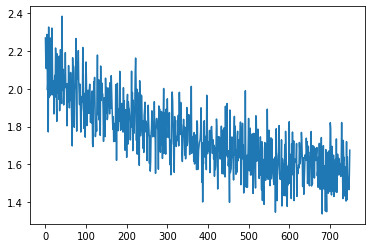

In [46]:
%matplotlib inline
showPlot(plot_losses)

Some additional loss reduction is seen, but with slow progress and still not at the same loss as the original model. Adjusting the learning rate or forcing rate might help, but I'll stop here for now.

In [47]:
# Always save the model!
model_path = '/home/team3/IDS576/models'

with open(model_path+'/eng-ita_encoder2.pkl', 'wb') as f:
    pickle.dump(encoder2, f)
with open(model_path+'/eng-ita_attn_decoder2.pkl', 'wb') as f:
    pickle.dump(attn_decoder2, f)

In [48]:
# Load the model
import pickle
model_path = '/home/team3/IDS576/models'

with open(f'{model_path}/eng-ita_encoder2.pkl', 'rb') as f:
    encoder2 = pickle.load(f)
    
with open(f'{model_path}/eng-ita_attn_decoder2.pkl', 'rb') as f:
    attn_decoder2 = pickle.load(f)

In [51]:
import warnings
warnings.filterwarnings("ignore")
evaluateRandomly(pairs, encoder2, attn_decoder2)
warnings.filterwarnings("default")

> we re competitive .
= noi siamo competitive .
< noi siamo decisive . <EOS>

> they re trapped .
= sono intrappolati .
< sono intrappolate . <EOS>

> i m from boston .
= vengo da boston .
< io sono da boston . <EOS>

> he is busy with his work .
= lui e occupato con il suo lavoro .
< e occupato col suo lavoro . <EOS>

> i m angry with you .
= sono arrabbiato con voi .
< sono arrabbiato con voi . <EOS>

> i m falling in love with you .
= mi sto innamorando di voi .
< mi sto innamorando di . . <EOS>

> we re going to do our best .
= noi faremo del nostro meglio .
< faremo del nostro meglio . <EOS>

> you re too generous .
= sei troppo generoso .
< lei e troppo . <EOS>

> he s a true legend .
= e una vera leggenda .
< e un un grande . <EOS>

> i m not deaf .
= non sono sorda .
< io non sono sordo . <EOS>



#### 2.3. Input 5 well-formed English sentences into Model 2 and then input the resulting translated sentences into Model 1. Display all model outputs.

In [52]:
eval_pairs = [
    ['i am always grateful for your help .', 'sono sempre grato per il tuo aiuto .'],
    ['he s a good student .','e un bravo studente .'],
    ['she is very bad at swimming .','lei e molto cattiva nel nuoto .'],
    ['we love working on homework together !','ci piace lavorare insieme sui compiti !'],
    ['they are not going to leave tomorrow .','non partiranno domani .'],
    ['when are they working out ?', 'quando stanno lavorando ?']
]

In [53]:
warnings.filterwarnings("ignore")
output_pairs = evaluateBatch(eval_pairs, encoder2, attn_decoder2)
warnings.filterwarnings("default")

> i am always grateful for your help .
= sono sempre grato per il tuo aiuto .
< sono sempre il suo aiuto . . <EOS>

> he s a good student .
= e un bravo studente .
< e un bravo bravo . <EOS>

> she is very bad at swimming .
= lei e molto cattiva nel nuoto .
< lei e molto a nuotare . <EOS>

> we love working on homework together !
= ci piace lavorare insieme sui compiti !
< ci stiamo lavorando a vero ? <EOS>

> they are not going to leave tomorrow .
= non partiranno domani .
< loro non stanno . <EOS>

> when are they working out ?
= quando stanno lavorando ?
< noi stiamo lavorando . . <EOS>



In [54]:
# Swap language definitions
input_lang, output_lang = output_lang, input_lang
print(f'Input language is now: {input_lang.name}')
print(f'Output language is now: {output_lang.name}')

Input language is now: ita
Output language is now: eng


Now we evaluate the output of Model 2 with Model 1 after swapping input and output languages above.

In [55]:
warnings.filterwarnings("ignore")
double_output_pairs = evaluateBatch(output_pairs, encoder1, attn_decoder1)
warnings.filterwarnings("default")

> sono sempre il suo aiuto . . <EOS>
= i am always grateful for your help .
< i m always your help . <EOS>

> e un bravo bravo . <EOS>
= he s a good student .
< you is a good player . <EOS>

> lei e molto a nuotare . <EOS>
= she is very bad at swimming .
< you re very brave in swimming . <EOS>

> ci stiamo lavorando a vero ? <EOS>
= we love working on homework together !
< we re working about you aren t you ? <EOS>

> loro non stanno . <EOS>
= they are not going to leave tomorrow .
< they re not they . <EOS>

> noi stiamo lavorando . . <EOS>
= when are they working out ?
< we re working . <EOS>



While none of the sentences are anywhere close to perfect, they are at least similar to the original english! Also, we see several double periods, which isn't ideal, but might be an artifact of teacher forcing inserting a period token following another period during training.

For next steps, I would retrain the both models with fewer filters and longer max length, to allow for translation of more interesting sentences and to allow more chance to train on different word constructions. Also, adding additional layers and birectionality, with a MUCH longer training time should improve performance.